In [1]:
from keras.applications import vgg16,inception_v3,resnet50

vgg = vgg16.VGG16()

Using TensorFlow backend.


In [2]:
from __future__ import print_function

import os
import time

import numpy as np

from scipy.optimize import fmin_l_bfgs_b

from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16
from keras import backend as K

from matplotlib import pylab as plt

In [5]:
base_image_path = os.path.join("resources","girl.jpg")
style_reference_image_path = os.path.join("resources","stylish_mural.jpeg")
results_images_path = os.path.join("results")

# these are the weights of the different loss components
total_variation_weight = 0.1e-7
style_weight = 0.2e6
content_weight = 0.001

# dimensions of the generated picture.
img_nrows = 200
img_ncols = 200
assert img_ncols == img_nrows, 'Due to the use of the Gram matrix, width and height must match.'

# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG16 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [8]:
# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [9]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [10]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [11]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, 1:, :img_ncols-1, :])
    b = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, :img_nrows-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [12]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1','block4_conv2',]
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [13]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Start of iteration 0
Current loss value: 1.08002e+15


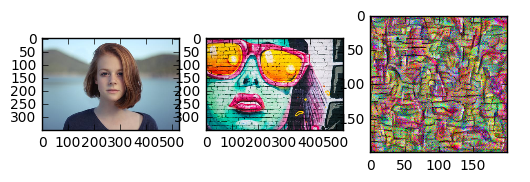

Iteration 0 completed in 96s
Start of iteration 1
Current loss value: 3.48985e+14


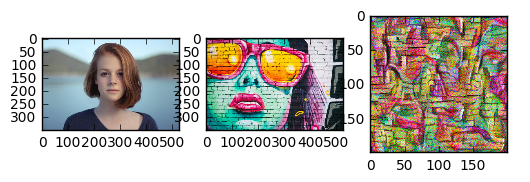

Iteration 1 completed in 99s
Start of iteration 2
Current loss value: 1.96635e+14


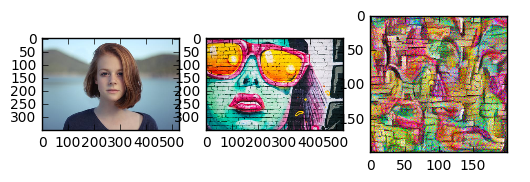

Iteration 2 completed in 98s
Start of iteration 3
Current loss value: 1.468e+14


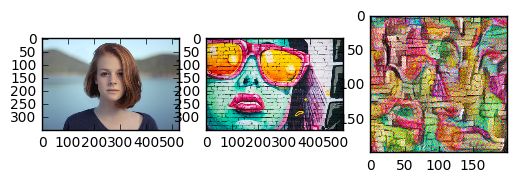

Iteration 3 completed in 110s
Start of iteration 4


KeyboardInterrupt: 

In [14]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.

for i in range(100):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    plt.imsave(os.path.join(results_images_path,"style_transfer_%s.jpg"%i),img)
    
    plt.subplot(131)
    plt.imshow(plt.imread(base_image_path))
    plt.subplot(132)
    plt.imshow(plt.imread(style_reference_image_path))
    plt.subplot(133)
    plt.imshow(img)
    plt.show()
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))